In [3]:
!pip install langgraph langchain langchain_groq langchain_community

In [5]:
!pip install arxiv wikipedia

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached beautifulsoup4-4.12.3-py3-none-any.whl.metadata (3.8 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached soupsieve-2.6-py3-none-any.whl.metadata (4.6 kB)
Using cached beautifulsoup4-4.12.3-py3-none-any.whl (147 kB)
Using cached soupsieve-2.6-py3-none-any.whl (36 kB)
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11706 sha256=

In [4]:
from typing import Annotated
from typing_extensions import TypedDict

In [6]:
## Working With Tools

from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

## Arxiv tool
arxiv_wrapp = ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=500)
arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_wrapp)

#wikitool

wiki_wrapp = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500)
wiki_tool = WikipediaQueryRun(api_wrapper=wiki_wrapp)

In [8]:
wiki_tool.invoke("who is prashant")

'Page: Prashant Kishor\nSummary: Prashant Kishor Pandey, colloquially known as PK, is an Indian political strategist and tactician. He worked in public health programmes funded by the United Nations for eight years before venturing into Indian politics and working as a political strategist.\nKishor has worked as a political  strategist for BJP to gain his knowledge then he worked for the BJP, JD(U), INC, AAP, YSRCP, DMK and TMC. His first major political campaign was in 2011 to help Narendra Modi, '

In [10]:
arxiv_tool.invoke("LLM Defenses Are Not Robust to Multi-Turn Human Jailbreaks Yet")

"Published: 2024-08-27\nTitle: LLM Defenses Are Not Robust to Multi-Turn Human Jailbreaks Yet\nAuthors: Nathaniel Li, Ziwen Han, Ian Steneker, Willow Primack, Riley Goodside, Hugh Zhang, Zifan Wang, Cristina Menghini, Summer Yue\nSummary: Recent large language model (LLM) defenses have greatly improved models'\nability to refuse harmful queries, even when adversarially attacked. However,\nLLM defenses are primarily evaluated against automated adversarial attacks in a\nsingle turn of conversation, an in"

In [11]:
tools = [wiki_tool, arxiv_tool]

In [12]:
## Langgraph

from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

In [13]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(State)

In [16]:
##LLM

import os 
from dotenv import load_dotenv

load_dotenv()

GROQ_API_KEY = os.getenv("GROQ_API_KEY")

from langchain_groq import ChatGroq

llm = ChatGroq(model = "llama-3.1-8b-instant",
            temperature=0.0,
            groq_api_key = GROQ_API_KEY)


In [17]:
llm_with_tools = llm.bind_tools(tools=tools)

In [18]:
def chatbot(state:State):
    return {"massages":[llm_with_tools.invoke(state['messages'])]}

In [19]:
from langgraph.prebuilt import ToolNode, tools_condition

In [20]:
graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges("chatbot", tools_condition)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [21]:
graph = graph_builder.compile()

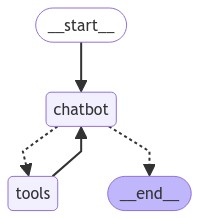

In [22]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass